In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import bempp.api
from bempp.api import shapes
import bempp_cavity

# Define Mesh

In [3]:
ELEMENT_SIZE = 0.5
LENGTH_CAVITY = 1
LENGTH_WALL = 3

In [4]:
inner_walls = [
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(-1.25, -1/2, -1.25)
    ),
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(0.25, -1/2, -1.25)
    ),
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(-1.25, -1/2, 0.25)
    ),
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(0.25, -1/2, 0.25)
    ),
    
]
outer_wall = shapes.cube(
        length=LENGTH_WALL, h=ELEMENT_SIZE,
        origin=(-LENGTH_WALL/2, -LENGTH_WALL/2, -LENGTH_WALL/2)
)
grid = bempp_cavity.create_grid(outer_wall, *inner_walls)

# Define Parameters and incident wave

In [5]:
Ks = [1, 1, 1, 1, 1, 1]
MUs = [1, 1, 1, 1, 1, 1]
wave = bempp_cavity.IncidentWave(Ks[0], MUs[0])

1 1


In [6]:
parameters = bempp_cavity.Parameters(
    nearfield_cutoff=1.0,
    ACA=0.1,
    quadrature=(1, 1, 1, 1)
)

# Create Models and Solve Them

In [ ]:
sol_sf = {}
sol_wf = {}

In [9]:
methods = [
    'self',
    'diagonal',
    'none', 
]

In [ ]:
for method in methods:
    print(method)
    model_sf = bempp_cavity.Model(grid, Ks, MUs, wave)
    sol_sf[method] = model_sf.solve(preconditioner=method)

In [8]:
for method in methods:
    print(method)
    model_wf = bempp_cavity.Model(grid, Ks, MUs, wave, spaces='RWG-dominant')
    sol_wf[method] = model_wf.solve(preconditioner=method, preconditioner_parameters=parameters.get())


method
method
method


# Analyse Results

## Convergence

In [11]:
sol_wf

{}

In [10]:
for method in methods:
    plt.semilogy(sol_sf[method].residuals, label='st-'+method)
for method in methods:
    plt.semilogy(sol_wf[method].residuals, label='wk-'+method)
plt.legend()
plt.show();

KeyError: 'self'

## Runtime

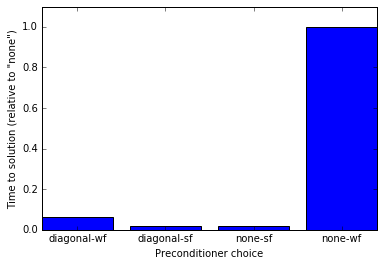

In [20]:
#
# Plot bar chart of run times
#
sol = {}
for k, v in sol_sf.items():
    sol[k+'-sf'] = v
for k, v in sol_wf.items():
    sol[k+'-wf'] = v
ref = sol['none-wf'].info['time_solve']
x = [i for i, _ in enumerate(sol.keys())]
times = [sol[method].info['time_solve']/ref for method in sol.keys()]
xlabels = list(sol.keys())

fig, ax = plt.subplots(1, 1)
plt.setp(ax, xticks=x, xticklabels=xlabels)


ax.bar(x, times, align='center');
ax.set_ylim([0, 1.1])
ax.set_xlabel('Preconditioner choice')
ax.set_ylabel('Time to solution (relative to "none")')
pass

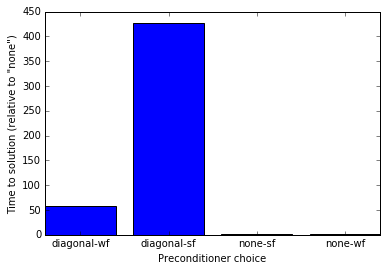

In [25]:
#
# Plot bar chart of run times
#
metric = 'time_assemble'
sol = {}
for k, v in sol_sf.items():
    sol[k+'-sf'] = v
for k, v in sol_wf.items():
    sol[k+'-wf'] = v
ref = sol['none-wf'].info[metric]
x = [i for i, _ in enumerate(sol.keys())]
times = [sol[method].info[metric]/ref for method in sol.keys()]
xlabels = list(sol.keys())

fig, ax = plt.subplots(1, 1)
plt.setp(ax, xticks=x, xticklabels=xlabels)


ax.bar(x, times, align='center');
# ax.set_ylim([0, 1.1])
ax.set_xlabel('Preconditioner choice')
ax.set_ylabel('Time to solution (relative to "none")')

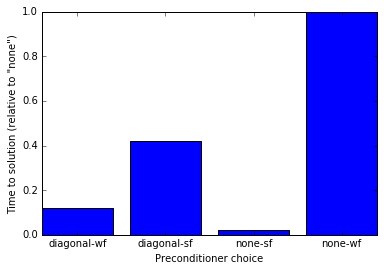

In [26]:
#
# Plot bar chart of run times
#
# metric = 'time_assemble'
sol = {}
for k, v in sol_sf.items():
    sol[k+'-sf'] = v
for k, v in sol_wf.items():
    sol[k+'-wf'] = v
ref = sol['none-wf'].info['time_solve'] + sol['none-wf'].info['time_assemble']
x = [i for i, _ in enumerate(sol.keys())]
times = [(sol[method].info['time_solve'] + sol[method].info['time_assemble'])/ref for method in sol.keys()]
xlabels = list(sol.keys())

fig, ax = plt.subplots(1, 1)
plt.setp(ax, xticks=x, xticklabels=xlabels)


ax.bar(x, times, align='center');
# ax.set_ylim([0, 1.1])
ax.set_xlabel('Preconditioner choice')
ax.set_ylabel('Time to solution (relative to "none")')

In [23]:
sol_sf['none'].info

{'matvec_count': 1080,
 'status': 0,
 'time_assemble': 2.868670000000293,
 'time_solve': 24.994410999999673}

In [26]:
# Average time per matvec
for m in methods:
    print(m, sol[m].info['time_solve']/sol[m].info['matvec_count'])

none 0.023014561111110905


# Memory Requirement

In [28]:
#
# Plot bar chart of run times
#
# ref = sol['none'].get_total_memory_size()
# x = [i for i, _ in enumerate(methods)]
# times = [sol[method].get_total_memory_size()/ref for method in methods]
# xlabels = methods

# fig, ax = plt.subplots(1, 1)
# plt.setp(ax, xticks=x, xticklabels=xlabels)


# ax.bar(x, times, align='center');
# ax.set_ylim([0, 1.1])
# ax.set_xlabel('Preconditioner choice')
# ax.set_ylabel('Memory')

# Sanity Check

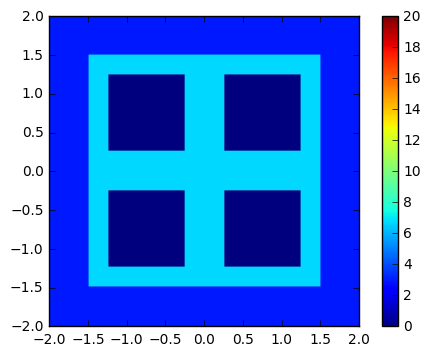

In [15]:
sol_sf.show_domains()

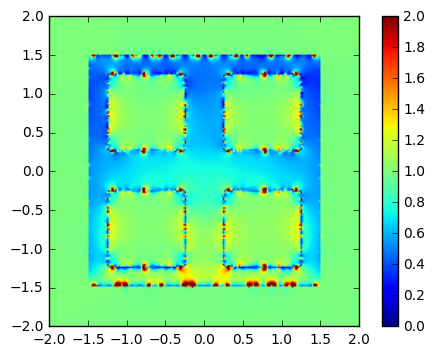

In [83]:
sol_sf['none'].plot()

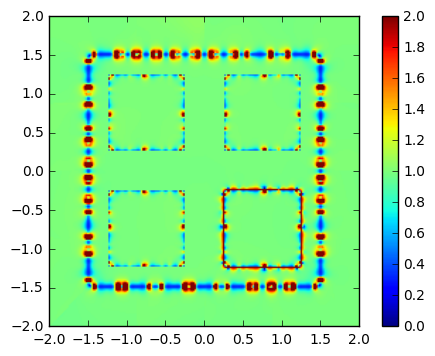

In [13]:
sol_wf['diagonal'].plot()

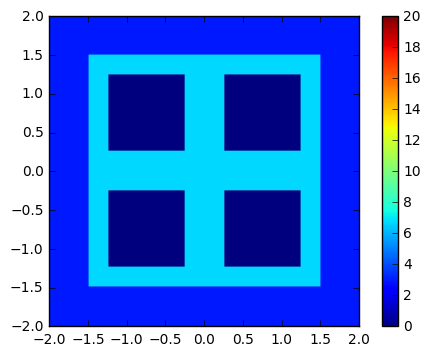

In [63]:
sol_wf['none'].show_domains()

In [65]:
sol_wf['none']._traces is None

True